In [ ]:
# ===================== Conditional VAE (CVAE) for tabular DDoS data =====================
# Assumes: df_sel, SELECTED_FEATURES, TARGET_COL already defined, and scaler fit on SELECTED_FEATURES.
# If scaler doesn't exist or was fit incorrectly, code will refit it below.

import os, time
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import ks_2samp, entropy, wasserstein_distance
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import shutil
from google.colab import drive
drive.mount("/content/gdrive")
# Change the code below if the path to the dataset is different for you.
shutil.unpack_archive("/content/gdrive/MyDrive/ddos_dataset.zip", "/tmp/")

Mounted at /content/gdrive


In [ ]:
CSV_PATH = r"/tmp/dataset_sdn.csv"   # kendi dataset yolunu yaz
SELECTED_FEATURES = [
    'dt','pktcount','bytecount','dur','tot_dur','packetins',
    'pktperflow','byteperflow','pktrate','tx_bytes'
]

TARGET_COL = None
SEED = 42
EPOCHS = 100
BATCH_SIZE = 256
LATENT_DIM = 16
HIDDEN_DIM = 128
LR = 5e-4
KL_WARMUP_FRAC = 0.25   # fraction of total steps used for linear annealing
POSITIVE_FEATURES = ['pktperflow', 'byteperflow', 'pktrate']  # ensure >=0
MODEL_DIR = "models_cvae"
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# ========== Load and preprocess ==========
df = pd.read_csv(CSV_PATH, low_memory=False)
if TARGET_COL is None:
    for cand in ['label','Label','class','Class','attack','Attack','target','Target','flow_label']:
        if cand in df.columns:
            TARGET_COL = cand
            break
    if TARGET_COL is None:
        TARGET_COL = df.columns[-1]
print("Using target column:", TARGET_COL)

use_cols = [c for c in SELECTED_FEATURES if c in df.columns] + [TARGET_COL]
df_sel = df[use_cols].dropna().reset_index(drop=True)

if df_sel[TARGET_COL].dtype != int:
    df_sel[TARGET_COL] = pd.factorize(df_sel[TARGET_COL])[0]

Using target column: label


In [ ]:
# --- Prepare data (use df_sel from your notebook) ---

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

df = df_sel.copy().reset_index(drop=True)
features = [c for c in SELECTED_FEATURES if c in df.columns]
if len(features) != len(SELECTED_FEATURES):
    print("Warning: SELECTED_FEATURES filtered to existing columns:", features)

X_raw = df[features].astype(float)
y_raw = df[TARGET_COL].astype(int).values  # shape (N,)

# Refit scaler safely on ONLY features

scaler = StandardScaler()
scaler.fit(X_raw.values)
X_scaled = scaler.fit_transform( X_raw.values)

#scaler = MinMaxScaler()
#scaler.fit(X_raw.values)
#X_scaled = scaler.transform(X_raw.values)




# Force encoder to always expect [0,1] classes
oh = OneHotEncoder(categories=[[0,1]], sparse_output=False, handle_unknown='ignore')
y_oh = oh.fit_transform(y_raw.reshape(-1,1))
n_classes = y_oh.shape[1]

print("Classes:", oh.categories_, "n_classes:", n_classes)



# Train/val split on real data (we will use val to test TSTR)
X_train_real, X_val_real, y_train_real, y_val_real, y_train_oh, y_val_oh = train_test_split(
    X_scaled, y_raw, y_oh, test_size=0.1, random_state=SEED, stratify=y_raw
)
print("Train real:", X_train_real.shape, "Val real:", X_val_real.shape)

Classes: [array([0, 1])] n_classes: 2
Train real: (93910, 10) Val real: (10435, 10)


In [ ]:
# Torch dataset
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y_oh):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y_oh, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = torch.utils.data.DataLoader(TabularDataset(X_train_real, y_train_oh),
                                           batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

input_dim = X_scaled.shape[1]
cond_dim = n_classes
print("Input dim:", input_dim, "Cond dim:", cond_dim)

Input dim: 10 Cond dim: 2


In [ ]:
# ---------------- CVAE model ----------------
class CVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim, hidden_dim):
        super().__init__()
        enc_in = input_dim + cond_dim
        self.enc = nn.Sequential(
            nn.Linear(enc_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU()
        )
        self.mu = nn.Linear(hidden_dim//2, latent_dim)
        self.logvar = nn.Linear(hidden_dim//2, latent_dim)

        dec_in = latent_dim + cond_dim
        self.dec = nn.Sequential(
            nn.Linear(dec_in, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()   # outputs in [0,1] to match scaler
        )

    def encode(self, x, c):
        inp = torch.cat([x, c], dim=1)
        h = self.enc(inp)
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        inp = torch.cat([z, c], dim=1)
        return self.dec(inp)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, c)
        return recon, mu, logvar

cvae = CVAE(input_dim=input_dim, cond_dim=cond_dim, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM).to(device)
opt = torch.optim.Adam(cvae.parameters(), lr=LR)

# Loss helpers
def recon_loss_fn(x_recon, x_true):
    # MSE averaged per batch
    return F.mse_loss(x_recon, x_true, reduction='mean')

def kl_loss_fn(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

In [ ]:
# Training with KL annealing
total_steps = EPOCHS * len(train_loader)
global_step = 0
warmup_steps = max(1, int(KL_WARMUP_FRAC * total_steps))

history = {'total':[], 'recon':[], 'kl':[]}
start = time.time()
for epoch in range(1, EPOCHS+1):
    cvae.train()
    epoch_recon = epoch_kl = epoch_total = 0.0
    batches = 0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        opt.zero_grad()
        recon, mu, logvar = cvae(xb, yb)
        recon_l = recon_loss_fn(recon, xb)
        kl_l = kl_loss_fn(mu, logvar)
        kl_weight = min(1.0, global_step / warmup_steps)
        loss = recon_l + kl_weight * kl_l
        loss.backward()
        opt.step()

        epoch_recon += recon_l.item()
        epoch_kl += kl_l.item()
        epoch_total += loss.item()
        global_step += 1
        batches += 1

    history['recon'].append(epoch_recon / batches)
    history['kl'].append(epoch_kl / batches)
    history['total'].append(epoch_total / batches)

    if epoch % 5 == 0 or epoch==1:
        elapsed = time.time() - start
        print(f"Epoch {epoch}/{EPOCHS} | Total: {history['total'][-1]:.6f} | Recon: {history['recon'][-1]:.6f} | KL: {history['kl'][-1]:.6f} | kl_w={kl_weight:.3f} | elapsed {elapsed:.1f}s")

Epoch 1/100 | Total: 0.767291 | Recon: 0.745281 | KL: 1.065875 | kl_w=0.040 | elapsed 1.5s
Epoch 5/100 | Total: 0.635254 | Recon: 0.581860 | KL: 0.297250 | kl_w=0.200 | elapsed 8.4s
Epoch 10/100 | Total: 0.673760 | Recon: 0.589716 | KL: 0.221306 | kl_w=0.400 | elapsed 16.1s
Epoch 15/100 | Total: 0.710590 | Recon: 0.603799 | KL: 0.184183 | kl_w=0.600 | elapsed 24.7s
Epoch 20/100 | Total: 0.741170 | Recon: 0.620642 | KL: 0.154545 | kl_w=0.800 | elapsed 33.2s
Epoch 25/100 | Total: 0.764969 | Recon: 0.634582 | KL: 0.133065 | kl_w=1.000 | elapsed 41.1s
Epoch 30/100 | Total: 0.767214 | Recon: 0.636360 | KL: 0.130854 | kl_w=1.000 | elapsed 49.7s
Epoch 35/100 | Total: 0.766084 | Recon: 0.636400 | KL: 0.129685 | kl_w=1.000 | elapsed 58.0s
Epoch 40/100 | Total: 0.765011 | Recon: 0.634516 | KL: 0.130494 | kl_w=1.000 | elapsed 65.9s
Epoch 45/100 | Total: 0.764146 | Recon: 0.634206 | KL: 0.129940 | kl_w=1.000 | elapsed 75.1s
Epoch 50/100 | Total: 0.763686 | Recon: 0.632693 | KL: 0.130993 | kl_w=1.0

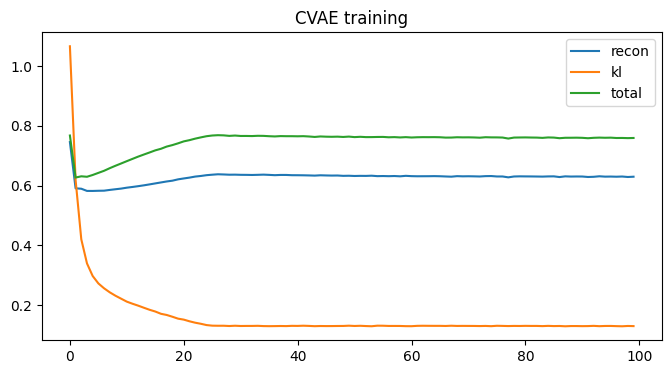

In [ ]:
# plot training curves
plt.figure(figsize=(8,4))
plt.plot(history['recon'], label='recon')
plt.plot(history['kl'], label='kl')
plt.plot(history['total'], label='total')
plt.legend(); plt.title('CVAE training'); plt.show()

In [ ]:
# ================= Sampling (conditional) =================
cvae.eval()
@torch.no_grad()
def sample_cvae(n_samples=1000, label_int=0):
    # create conditional vector
    label_vec = np.array([label_int]*n_samples).reshape(-1,1)
    label_oh = oh.transform(label_vec)   # shape (n_samples, n_classes)
    label_t = torch.tensor(label_oh, dtype=torch.float32, device=device)
    z = torch.randn(n_samples, LATENT_DIM, device=device)
    recon = cvae.decode(z, label_t).cpu().numpy()
    # clamp to [0,1]
    recon = np.clip(recon, 0.0, 1.0)
    # inverse transform to original scale
    inv = scaler.inverse_transform(recon)
    # postprocess: ensure physically non-negative features are >=0
    for col in POSITIVE_FEATURES:
        if col in features:
            idx = features.index(col)
            inv[:, idx] = np.where(inv[:, idx] < 0, 0, inv[:, idx])
    return inv


In [ ]:
# generate synthetic per class
n_per_class = 2500   # for two-class -> 5k total
synth_list = []
for class_int in range(n_classes):
    arr = sample_cvae(n_per_class, label_int=class_int)
    dfc = pd.DataFrame(arr, columns=features)
    dfc[TARGET_COL] = class_int
    synth_list.append(dfc)
synthetic_df = pd.concat(synth_list, ignore_index=True)
print("Synthetic shape:", synthetic_df.shape)

# quick head
display(synthetic_df.head(10))

Synthetic shape: (5000, 11)


,dt,pktcount,bytecount,dur,tot_dur,packetins,pktperflow,byteperflow,pktrate,tx_bytes,label
0,29904.884766,52860.953125,38186596.0,390.933655,3.955124e+11,5200.383301,6381.715332,4716150.0,212.210678,110183800.0,0
1,29898.056641,52860.953125,38186596.0,321.497406,3.218865e+11,5200.383301,6381.715332,4716150.0,212.210678,93252648.0,0
2,17929.179688,102913.507812,86955768.0,321.498169,3.218873e+11,10240.355469,13301.350586,12272582.0,443.426208,175492976.0,0
3,17952.914062,52860.953125,38186596.0,321.506561,3.218965e+11,5200.387207,6381.717773,4716150.0,212.210754,99550240.0,0
4,18184.148438,52860.953125,38186596.0,604.804932,6.050546e+11,5200.383301,6381.715332,4716150.0,212.210678,93252968.0,0
5,18579.109375,56517.910156,48119724.0,321.497589,3.218867e+11,10433.610352,12972.410156,11828075.0,430.395386,93252648.0,0
6,17927.513672,103442.578125,86963512.0,321.497406,3.218865e+11,5202.542969,13383.322266,12275955.0,445.970398,93252792.0,0
7,17927.513672,99899.835938,86959568.0,321.497406,3.218865e+11,5200.688965,13499.624023,12275983.0,449.369537,93358016.0,0
8,17927.513672,84376.414062,86755792.0,321.497437,3.218865e+11,5200.513672,13442.702148,12274688.0,446.576752,93252664.0,0
9,18951.544922,52861.023438,38186596.0,321.497467,3.218866e+11,10233.235352,6545.756836,4716150.0,217.717285,245189440.0,0



Feature similarity metrics:


,Feature,KS_stat,KS_p,KL_div,Wasserstein
0,packetins,0.716191,0.0,2.947076,2.920564e+03
1,tx_bytes,0.666903,0.0,0.580593,9.066113e+07
2,dur,0.645541,0.0,1.604227,1.557770e+02
3,tot_dur,0.644928,0.0,0.011019,1.557100e+11
4,bytecount,0.639916,0.0,0.617995,2.911825e+07
5,byteperflow,0.599760,0.0,4.609973,3.548960e+06
6,dt,0.563391,0.0,2.512438,8.132949e+03
7,pktcount,0.553452,0.0,0.963081,2.873495e+04
8,pktrate,0.412535,0.0,3.132048,1.066998e+02
9,pktperflow,0.412056,0.0,3.346008,3.196656e+03


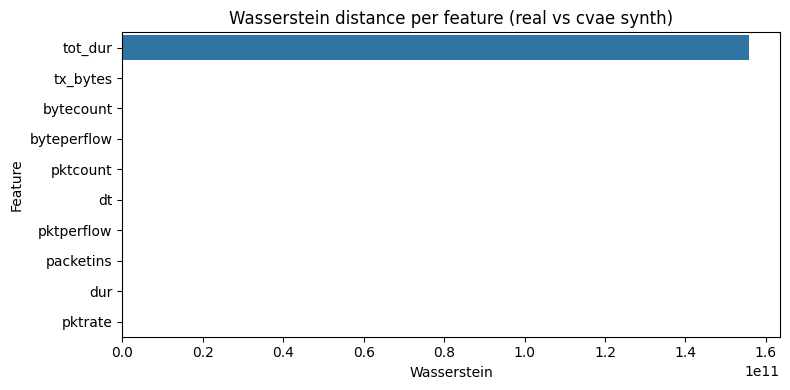

In [ ]:
# ================= Stats: KS, KL (hist), Wasserstein =================
def kl_hist(a,b,bins=100):
    pa,_ = np.histogram(a, bins=bins, density=True)
    pb,_ = np.histogram(b, bins=bins, density=True)
    pa += 1e-10; pb += 1e-10
    return entropy(pa,pb)

metrics=[]
for col in features:
    real_col = X_raw[col].values
    synth_col = synthetic_df[col].values
    ks_stat, ks_p = ks_2samp(real_col, synth_col)
    klv = kl_hist(real_col, synth_col, bins=100)
    w = wasserstein_distance(real_col, synth_col)
    metrics.append((col, ks_stat, ks_p, klv, w))
metrics_df = pd.DataFrame(metrics, columns=['Feature','KS_stat','KS_p','KL_div','Wasserstein'])
metrics_df = metrics_df.sort_values('KS_stat', ascending=False).reset_index(drop=True)
print("\nFeature similarity metrics:")
display(metrics_df)

# barplot for wasserstein
plt.figure(figsize=(8,4))
sns.barplot(x='Wasserstein', y='Feature', data=metrics_df.sort_values('Wasserstein', ascending=False))
plt.title('Wasserstein distance per feature (real vs cvae synth)')
plt.tight_layout(); plt.show()

In [ ]:
# ================= TSTR: Train on Synthetic (labelled), Test on Real validation =================
X_synth = synthetic_df[features].values
y_synth = synthetic_df[TARGET_COL].values

clf = RandomForestClassifier(n_estimators=300, random_state=SEED, n_jobs=-1)
clf.fit(X_synth, y_synth)
y_pred = clf.predict(X_val_real)

acc = accuracy_score(y_val_real, y_pred)
print("\n=== TSTR Evaluation ===")
print(f"Accuracy on real validation set: {acc:.4f}")
# Uyarıyı gidermek için zero_division=0 parametresini ekleyin
print(classification_report(y_val_real, y_pred, digits=4, zero_division=0))

# two-sample classifier (real vs synthetic separability)
real_marker = np.ones(len(X_val_real), dtype=int)
synth_marker = np.zeros(len(X_synth), dtype=int)
X_comb = np.vstack([X_val_real, X_synth])
y_comb = np.concatenate([real_marker, synth_marker])
clf_ts = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
clf_ts.fit(X_comb, y_comb)
yhat = clf_ts.predict(X_comb)
acc_ts = accuracy_score(y_comb, yhat)
print(f"\nTwo-sample classifier accuracy (real vs synth separability): {acc_ts:.4f}  (lower ~0.5 better)")



=== TSTR Evaluation ===
Accuracy on real validation set: 0.6091
              precision    recall  f1-score   support

           0     0.6091    1.0000    0.7571      6356
           1     0.0000    0.0000    0.0000      4079

    accuracy                         0.6091     10435
   macro avg     0.3046    0.5000    0.3785     10435
weighted avg     0.3710    0.6091    0.4611     10435


Two-sample classifier accuracy (real vs synth separability): 1.0000  (lower ~0.5 better)


In [ ]:
# Save synthetic csv
outpath = os.path.join(MODEL_DIR, "synthetic_cvae.csv")
synthetic_df.to_csv(outpath, index=False)
print("Saved synthetic CSV to:", outpath)

Saved synthetic CSV to: models_cvae/synthetic_cvae.csv
